In [1]:
import camb
import healpy as hp
import pysm3
import pysm3.units as u
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import pickle as pl
import time
import pymaster as nmt
from types import SimpleNamespace

In [2]:
def arc2cl(arc):
    return np.radians(arc/60)**2
def cl2arc(cl):
    return np.rad2deg(np.sqrt(cl))*60
def noise(arr):
    return cl2arc(1/sum(1/arc2cl(arr)))

In [3]:
nside = 128

In [4]:
mfile = '/global/homes/l/lonappan/scratch/binary_GAL_mask_N1024.fits'
mask = hp.ud_grade(hp.read_map(mfile),nside)

In [5]:
maskc = nmt.mask_apodization(mask, 10, apotype="C1")

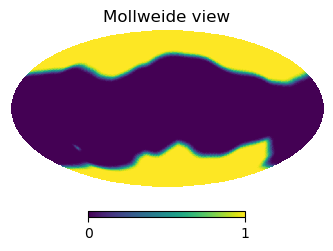

In [6]:
hp.mollview(maskc, sub=(1,2,1))

In [7]:
pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,  As=2e-9, ns=0.965, halofit_version='mead', lmax=7000)
results = camb.get_results(pars)
lensed_cl = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['lensed_scalar']
cmb_map = hp.synfast(lensed_cl.T, nside=nside, new=True)

In [8]:
bmap = hp.alm2map(hp.map2alm(cmb_map)[2], nside=nside)
emap = hp.alm2map(hp.map2alm(cmb_map)[1], nside=nside)

In [9]:
freqs = np.array(["27", "39", "93", "145", "225", "280"])
fwhm = np.array([7.4, 5.1, 2.2, 1.4, 1.0, 0.9])
nlev_p = np.array([23.6, 13.1, 2.3, 2.2, 4.8, 2.2])

In [10]:
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1"])

In [11]:
def noise_map(nside,nlev_p):
    nl_p = np.ones(3*nside) * np.radians(nlev_p / 60.)**2
    nlev_t = nlev_p / np.sqrt(2)
    nl_t = np.ones(3*nside) * np.radians(nlev_t / 60.)**2
    cl_s = [nl_t, nl_p, nl_p, nl_p*0]
    return hp.synfast(cl_s, nside=nside, new=True)

def sky_map_wfg(freqs, fwhm, nlev_p, nside):
    noise_maps = []
    cmb_maps = []
    fg_maps = []
    for i in tqdm(range(len(freqs))):
        fg = sky.get_emission(int(freqs[i])*u.GHz)
        fg = fg.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(int(freqs[i])*u.GHz))
        cmb_maps.append(hp.smoothing(cmb_map, fwhm=np.radians(fwhm[i]/60.)))
        fg_maps.append(hp.smoothing(fg.value, fwhm=np.radians(fwhm[i]/60.)))
        noise_maps.append(noise_map(nside, nlev_p[i]))
    noise_maps = np.array(noise_maps)
    cmb_maps = np.array(cmb_maps)
    fg_maps = np.array(fg_maps)
    total_maps = noise_maps + cmb_maps + fg_maps
    return noise_maps, cmb_maps, fg_maps, total_maps


In [12]:
noise_maps,cmb_maps,fg_maps,total_maps = sky_map_wfg(freqs, fwhm, nlev_p, nside)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:40<00:00,  6.67s/it]


In [13]:
sys.path.append('../')

In [14]:
fg_bmaps = []
fg_emaps = []
noise_bmaps = []
noise_emaps = []
total_bmaps = []
total_emaps = []
for i in tqdm(range(len(freqs))):
    fg_bmaps.append([hp.alm2map(hp.map2alm(fg_maps[i])[2], nside=nside)*maskc])
    fg_emaps.append([hp.alm2map(hp.map2alm(fg_maps[i])[1], nside=nside)*maskc])
    noise_bmaps.append([hp.alm2map(hp.map2alm(noise_maps[i])[2], nside=nside)*maskc])
    noise_emaps.append([hp.alm2map(hp.map2alm(noise_maps[i])[1], nside=nside)*maskc])
    total_bmaps.append([hp.alm2map(hp.map2alm(total_maps[i])[2], nside=nside)*maskc])
    total_emaps.append([hp.alm2map(hp.map2alm(total_maps[i])[1], nside=nside)*maskc])
fg_bmaps = np.array(fg_bmaps)
fg_emaps = np.array(fg_emaps)
noise_bmaps = np.array(noise_bmaps)
noise_emaps = np.array(noise_emaps)
total_bmaps = np.array(total_bmaps)
total_emaps = np.array(total_emaps)

100%|██████████| 6/6 [01:19<00:00, 13.20s/it]


In [15]:
%load_ext autoreload
%autoreload 2
from pynilc.nilc import NILC
from pynilc.needlets import NeedletTransform
from pynilc.sht import HealpixDUCC

In [16]:
bandcenters = np.array([0,100,200,250])
nfilters = NeedletTransform.CosineNeedlet(bandcenters,lmax=256)

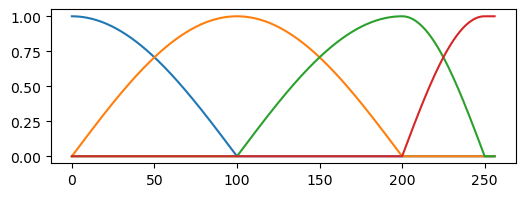

In [17]:
plt.figure(figsize=(6,2))
for i in range(len(nfilters)):
    plt.plot(nfilters[i])

In [36]:
cl_b_out = hp.anafast(bmap)
cl_e_out = hp.anafast(emap)

In [110]:
nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,required_num_modes=10,mask=maskc,ilc_bias=0.001,bias_method='tol')
ilc_bmap_dc, ilc_weights_b = nilc_dc.component_separation(total_bmaps)

Level 1 parallel processing is enabled
Computing temperature alms


Computing alms:   0%|          | 0/6 [00:00<?, ?it/s]

Processing Needlet Scales: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


In [111]:
nilc_dc = NILC(freqs, fwhm, nfilters, backend='ducc', nside=nside,required_num_modes=10,mask=maskc,ilc_bias=0.001,bias_method='tol')
ilc_emap_dc, ilc_weights_e = nilc_dc.component_separation(total_emaps)

Level 1 parallel processing is enabled
Computing temperature alms


Processing Needlet Scales: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


In [112]:
cl_b = hp.anafast(ilc_bmap_dc)
cl_e = hp.anafast(ilc_emap_dc)

In [113]:
noise_res_b = nilc_dc.calculate_residuals(noise_bmaps, ilc_weights_b,field=0)
fg_res_b = nilc_dc.calculate_residuals(fg_bmaps, ilc_weights_b,field=0)
noise_res_e = nilc_dc.calculate_residuals(noise_emaps, ilc_weights_e,field=0)
fg_res_e = nilc_dc.calculate_residuals(fg_emaps, ilc_weights_e,field=0)


Computing temperature alms


Calculating residuals:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating residuals: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Computing temperature alms


Calculating residuals: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Computing temperature alms


Calculating residuals: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Computing temperature alms


Calculating residuals: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


In [114]:
clean_blm = hp.map2alm(ilc_bmap_dc)
clean_elm = hp.map2alm(ilc_emap_dc)
clean_QU = hp.alm2map([clean_elm*0,clean_elm, clean_blm], nside)[1:]
fg_res_blm = hp.map2alm(fg_res_b)
fg_res_elm = hp.map2alm(fg_res_e)
fg_res_QU = hp.alm2map([fg_res_elm*0, fg_res_elm, fg_res_blm], nside)[1:]
noise_blm = hp.map2alm(noise_res_b)
noise_elm = hp.map2alm(noise_res_e)
noise_QU = hp.alm2map([noise_elm*0, noise_elm, noise_blm], nside)[1:]

In [25]:
from broom import (
    Configs,
    get_params, _compute_spectra,
    component_separation,_get_full_simulations, estimate_residuals, _combine_products)
from broom.needlets import _get_needlet_windows_

In [28]:
config = get_params(config_path='test.yaml')
config_run = {
    'compsep': [{
    'method': "ilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    # Needlet configuration
    'needlet_config':
      [{'needlet_windows': "cosine"},
       {'ell_peaks': [0,100,200,250]}],
    'reduce_ilc_bias': False,
    'b_squared': False,
    'save_needlets': True,
    'save_weights': True,
    'cov_noise_debias': [0.,0.,0.,0.]
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()
config.field_out = "QU"
config.mask_observations = 'maskc.fits'
config.mask_covariance = 'maskc.fits'
config.bring_to_common_resolution = True
config.instrument = SimpleNamespace(beams='gaussian',fwhm=fwhm,frequency=freqs)
config.return_compsep_products = True

In [27]:
data = SimpleNamespace(total=total_maps,fgds=fg_maps,noise=noise_maps)

In [29]:
outputs_nilc_noleak = component_separation(config, data, nsim = 0)

Computing required input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


In [84]:
mask_f = nmt.NmtField(maskc, [maskc, maskc], purify_b=True)
workspace = nmt.NmtWorkspace()
binInfo  = nmt.NmtBin.from_nside_linear(nside, 3)
workspace.compute_coupling_matrix(mask_f, mask_f, binInfo)
def compute_master(f_a,f_b):
    cl_coupled   = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = workspace.decouple_cell(cl_coupled)
    return cl_decoupled

In [115]:
clean_f = nmt.NmtField(maskc, clean_QU, purify_b=True)
fg_res_f = nmt.NmtField(maskc, fg_res_QU, purify_b=True)
noise_f = nmt.NmtField(maskc, noise_QU, purify_b=True)
cl_clean = compute_master(clean_f, clean_f)
cl_fg_res = compute_master(fg_res_f, fg_res_f)
cl_noise = compute_master(noise_f, noise_f)

In [108]:
clean_broom = nmt.NmtField(maskc, outputs_nilc_noleak.total[0], purify_b=True)
fg_broom = nmt.NmtField(maskc, outputs_nilc_noleak.fgds[0], purify_b=True)
noise_broom = nmt.NmtField(maskc, outputs_nilc_noleak.noise[0], purify_b=True)
cl_clean_broom = compute_master(clean_broom, clean_broom)
cl_fg_broom = compute_master(fg_broom, fg_broom)
cl_noise_broom = compute_master(noise_broom, noise_broom)

(1e-09, 0.001)

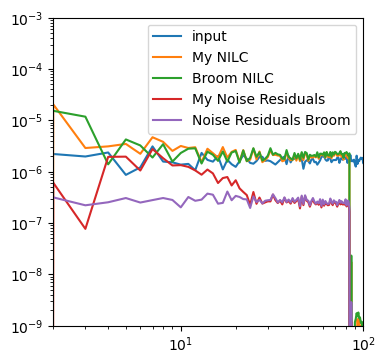

In [ ]:
plt.figure(figsize=(4, 4))
plt.loglog(cl_b_out, label='input')
plt.loglog(cl_clean[3], label='My NILC')
plt.loglog(cl_clean_broom[3], label='Broom NILC')
plt.loglog(cl_noise[3], label='My Noise Residuals')
plt.loglog(cl_noise_broom[3], label='Noise Residuals Broom')
plt.legend()
plt.xlim(2, 100)
plt.ylim(1e-9, 1e-3)

(1e-09, 0.001)

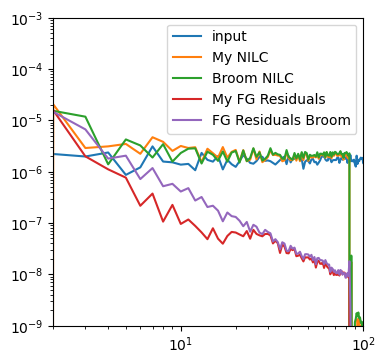

In [118]:
plt.figure(figsize=(4, 4))
plt.loglog(cl_b_out, label='input')
plt.loglog(cl_clean[3], label='My NILC')
plt.loglog(cl_clean_broom[3], label='Broom NILC')
plt.loglog(cl_fg_res[3], label='My FG Residuals')
plt.loglog(cl_fg_broom[3], label='FG Residuals Broom')
plt.legend()
plt.xlim(2, 100)
plt.ylim(1e-9, 1e-3)